In [1]:
''' mainly used to make sure that C nmr works better than HSQC'''

import torch
torch.set_printoptions(precision=10)

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from models.optional_input_ranked_transformer import OptionalInputRankedTransformer
from datasets.optional_2d_folder_dataset import OptionalInputDataModule
from datasets.hsqc_folder_dataset import FolderDataModule
import yaml
from pytorch_lightning.loggers import TensorBoardLogger
torch.set_float32_matmul_precision('medium')
from pathlib import Path

from rdkit import Chem
from rdkit.Chem import Draw
# load model 
from datasets import dataset_utils
from datasets.dataset_utils import specific_radius_mfp_loader

            


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np 
import random
seed=2
# pl.seed_everything(seed,  workers=True)
# torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed) 
np.random.seed(seed)
random.seed(seed)


In [3]:
# load model 

# Choice 1: flexible model
model_path = Path("/root/MorganFP_prediction/reproduce_previous_works/weird_H_and_tautomer_cleaned/flexible_models_best_FP/r0_r2_FP_trial_2/")
checkpoint_path = model_path / "checkpoints/epoch=42-all_inputs.ckpt"

# Choice  2: all-three nmr model
# model_path = Path("/root/MorganFP_prediction/reproduce_previous_works/weird_H_and_tautomer_cleaned/entropy_radius_exps_all_info/R0_to_R4_all_info_trial_1")
# checkpoint_path = model_path / "checkpoints/epoch=22-step=11408.ckpt"



hyperpaerameters_path = model_path / "hparams.yaml"

# checkpoint_path = model_path / "checkpoints/epoch=14-step=43515.ckpt"


with open(hyperpaerameters_path, 'r') as file:
    hparams = yaml.safe_load(file)
    
FP_building_type = hparams['FP_building_type'].split("_")[-1]
only_2d = not hparams['use_oneD_NMR_no_solvent']
print(FP_building_type)
max_radius = int(hparams['FP_choice'].split("_")[-1][1:])
print("max_radius: ", max_radius)
specific_radius_mfp_loader.setup(only_2d=only_2d,FP_building_type=FP_building_type)
specific_radius_mfp_loader.set_max_radius(int(hparams['FP_choice'].split("_")[-1][1:]), only_2d=only_2d)


del hparams['checkpoint_path'] # prevent double defition of checkpoint_path
hparams['use_peak_values'] = False




Normal
max_radius:  2


In [4]:

model = OptionalInputRankedTransformer.load_from_checkpoint(checkpoint_path, **hparams)


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


In [5]:
datamodule = OptionalInputDataModule(dir="/workspace/SMILES_dataset", FP_choice=hparams["FP_choice"], input_src=["HSQC", "oneD_NMR"], batch_size=1, parser_args=hparams)
datamodule.setup("predict")

loader_all_inputs, loader_HSQC_H_NMR, loader_HSQC_C_NMR, loader_only_hsqc, loader_only_1d, loader_only_H_NMR, loader_only_C_NMR = \
    datamodule.predict_dataloader()

# datamodule.setup("test")
# loader_only_hsqc = datamodule.test_dataloader()
    
# model=model.to("cuda")

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
# set up ranking set

import pickle 
choice = "test"
index_to_smiles = pickle.load(open(f'/workspace/SMILES_dataset/{choice}/SMILES/index.pkl', 'rb'))
folder_base = Path("/workspace/SMILES_dataset")



all_FP_indices_in_folder = pickle.load(open(f'/root/MorganFP_prediction/reproduce_previous_works/Spectre/datasets/{choice}_indices_of_full_info_NMRs.pkl', 'rb'))
all_added_smiles = set()
all_FP_indices_to_be_added = []
for i in all_FP_indices_in_folder:
    smile = index_to_smiles [int(i.split(".")[0])]
    if smile not in all_added_smiles:
        all_added_smiles.add(smile)
        all_FP_indices_to_be_added.append(i)
        
sorted_file_indices  = [int(file.split(".")[0]) for file in sorted(all_FP_indices_to_be_added)]
index_to_chemical_names = pickle.load(open(f'/workspace/SMILES_dataset/{choice}/Chemical/index.pkl', 'rb'))



In [7]:
# len(all_FP_indices_in_folder), len(all_added_smiles), len(all_FP_indices_to_be_added)

In [8]:
# visualize the all input one 
import os 

chemical_names_lookup = pickle.load(open(f'/workspace/SMILES_dataset/test/Chemical/index.pkl', 'rb'))
# chemical_names_lookup[2288]

all_file_indices = [int(i.split(".")[0]) for i in loader_only_hsqc.dataset.files]
all_chemicals = [chemical_names_lookup[file_idx] for file_idx in all_file_indices]
# for i, chemical in enumerate(all_chemicals):
#     print(i, chemical)

In [9]:
which_compound = 5
filename = loader_all_inputs.dataset.files[which_compound]

f_path = os.path.join(loader_all_inputs.dataset.dir, "oneD_NMR", filename)
if os.path.exists(f_path):
    c_tensor, h_tensor = torch.load(f_path)
    
hsqc = torch.load(f_path.replace("oneD_NMR", "HSQC"))

# print(f_path)
chemical_names_lookup = pickle.load(open(f'/workspace/SMILES_dataset/test/Chemical/index.pkl', 'rb'))
print(chemical_names_lookup[int(filename.split(".")[0])] + "\n" +index_to_smiles[int(filename.split(".")[0])])
print(filename)

Chemspider_Pyristriatin A
COC1OC2c3c(cnc(C(=O)CO)c31)CC(O)C1C3=C(C(C)C)CCC3(C)CCC21C
10022.pt


In [10]:
(index_to_smiles[int(filename.split(".")[0])], index_to_chemical_names[int(filename.split(".")[0])])

('COC1OC2c3c(cnc(C(=O)CO)c31)CC(O)C1C3=C(C(C)C)CCC3(C)CCC21C',
 'Chemspider_Pyristriatin A')

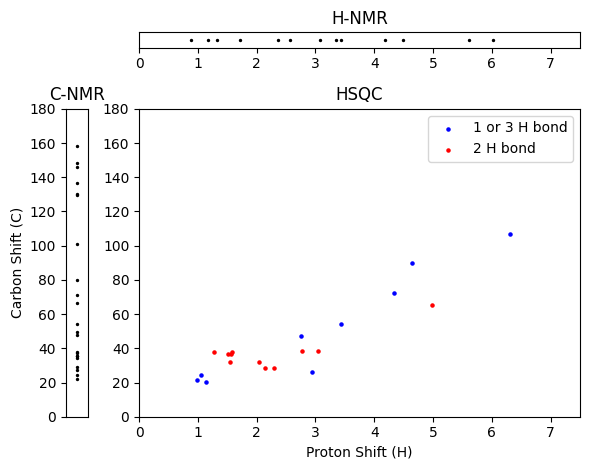

In [11]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_NMR(hsqc, c_tensor, h_tensor):
    # print(hsqc, c_tensor, h_tensor)
    # Create a 2x2 grid for subplots
    fig = plt.figure(figsize=(6, 4.8))  # Overall figure size
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 20], width_ratios=[1, 20])

    # Create subplots in different locations and sizes
    ax1 = fig.add_subplot(gs[1, 1])  # Takes up the first row
    if hsqc is not None:
        pos = hsqc[hsqc[:,2]>0]
        neg = hsqc[hsqc[:,2]<0]
        ax1.scatter(pos[:,1], pos[:,0], c="blue", label="1 or 3 H bond", s=5)
        ax1.scatter(neg[:,1], neg[:,0], c="red", label="2 H bond", s=5)
        # print("scatter!!")
        # print(pos, neg)
    ax1.set_title("HSQC")
    ax1.set_xlabel('Proton Shift (H)')  # X-axis label
    ax1.set_xlim([0, 7.5])
    ax1.set_ylim([0, 180])
    ax1.legend()


    ax2 = fig.add_subplot(gs[1, 0])  # Smaller subplot
    if c_tensor is not None:
        ax2.scatter( torch.ones(len(c_tensor)), c_tensor, c="black", s=2)
    ax2.set_ylim([0, 180])
    ax2.set_title("C-NMR")
    ax2.set_ylabel('Carbon Shift (C)')
    ax2.set_xticks([])

    ax3 = fig.add_subplot(gs[0, 1])  # Smaller subplot
    if h_tensor is not None:
        ax3.scatter(h_tensor, torch.ones(len(h_tensor)),c="black", s=2)
    ax3.set_xlim([0, 7.5])
    ax3.set_title("H-NMR")
    ax3.set_yticks([])

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Show the plot
    plt.show()

plot_NMR(hsqc, c_tensor, h_tensor)

In [12]:
import torch.nn.functional as F
import heapq

def retrieve_top_k_by_dir(dir, prediction_query, smiles_and_names , k=30):
    query = F.normalize(prediction_query, dim=1, p=2.0).squeeze()
    results = []
    for  ranker_f in sorted(os.listdir(dir), key=lambda x:int(x.split("_")[1].split(".")[0])):
    # for num_ranker_data, ranker_f in [(54,"FP_54.pt")]:
        # print(ranker_f)
        num_ranker_data = int(ranker_f.split("_")[1].split(".")[0])
        data = torch.load(os.path.join(dir, ranker_f)).to("cuda")
        query_products = (data @ query)
        values, indices = torch.topk(query_products,k=k)
        if len(results) == 0:
            for value, idx in zip(values, indices):
                real_idx = idx + 2000*num_ranker_data
                heapq.heappush(results, (value, real_idx, data[idx].nonzero()))
        else:
            for value, idx in zip(values, indices):
                real_idx = idx + 2000*num_ranker_data
                heapq.heappushpop(results, (value, real_idx, data[idx].nonzero()))    
                
                        
    results.sort(key=lambda x: x[0],reverse=True)
    ret = [(value, smiles_and_names[i], fp) for value, i, fp in results]
    # print(torch.tensor(idx))
    # retrieved_FP = [all_fp[i] for i in idx]
    # print(results[0])
  
    return ret

def retrieve_top_k_by_rankingset(data, prediction_query, smiles_and_names , k=30):
    query = F.normalize(prediction_query, dim=1, p=2.0).squeeze()

    results = []
    query_products = (data @ query)
    values, indices = torch.topk(query_products,k=k)
    
    for value, idx in zip(values, indices):
        results.append((value, idx, data[idx].nonzero()))
                
                        
    results.sort(key=lambda x: x[0],reverse=True)
    ret = [(value, smiles_and_names[i], fp) for value, i, fp in results]
    # print(torch.tensor(idx))
    # retrieved_FP = [all_fp[i] for i in idx]
    # print(results[0])
  
    return ret
        

In [13]:
# smiles_and_names = pickle.load(open(f'/root/MorganFP_prediction/inference_data/SMILES_chemical_names.pkl', 'rb'))
# smiles_and_names = pickle.load(open(f'/root/MorganFP_prediction/inference_data/SMILES_chemical_names_only_2d_dataset.pkl', 'rb'))
smiles_and_names = pickle.load(open(f'/root/MorganFP_prediction/inference_data/SMILES_chemical_names_remove_stereoChemistry.pkl', 'rb'))

# smiles_and_names = pickle.load(open(f'/root/MorganFP_prediction/inference_data/test_smiles_and_names.pkl', 'rb'))

In [14]:
# rankingset_path = '/root/MorganFP_prediction/inference_data/max_radius_2_only_2d_False_together_only_2d_dataset/FP.pt'
rankingset_path = f'/root/MorganFP_prediction/inference_data/max_radius_{max_radius}_only_2d_False_together_no_stereoChemistry_dataset/FP.pt'

rankingset_data = torch.load(rankingset_path).to("cuda")

smiles_to_NMR_path = pickle.load(open('/root/MorganFP_prediction/inference_data/SMILES_chemical_to_NMR_paths.pkl','rb'))

In [15]:
smiles_to_NMR_path['COC1OC(CO)C(O)C(O)C1O']

('/workspace/SMILES_dataset/test/HSQC/10002.pt',
 '/workspace/SMILES_dataset/test/oneD_NMR/10002.pt')

In [16]:
def unpack_inputs(inputs):
    for i, vals in enumerate(inputs[0]):
        # if vals is [-1, -1, -1]
        if vals[0]==-1 and vals[1]==-1 and vals[2]==-1:
            hsqc_start=i+1
        elif vals[0]==-2 and vals[1]==-2 and vals[2]==-2:
            hsqc_end=i
        elif vals[0]==-3 and vals[1]==-3 and vals[2]==-3:
            c_nmr_start=i+1
        elif vals[0]==-4 and vals[1]==-4 and vals[2]==-4:
            c_nmr_end=i
        elif vals[0]==-5 and vals[1]==-5 and vals[2]==-5:
            h_nmr_start=i+1
        elif vals[0]==-6 and vals[1]==-6 and vals[2]==-6:
            h_nmr_end=i
            
    hsqc = inputs[0,hsqc_start:hsqc_end]
    c_tensor = inputs[0,c_nmr_start:c_nmr_end,0]
    h_tensor = inputs[0,h_nmr_start:h_nmr_end,0]
    return hsqc, c_tensor, h_tensor

# unpack_inputs(inputs)

# !!!
def compute_cos_sim(fp1, fp2):
    return (fp1 @ fp2) / (torch.norm(fp1) * torch.norm(fp2)).item()

############################################### compound number: 3536##############################################################
Ground Truth NMR


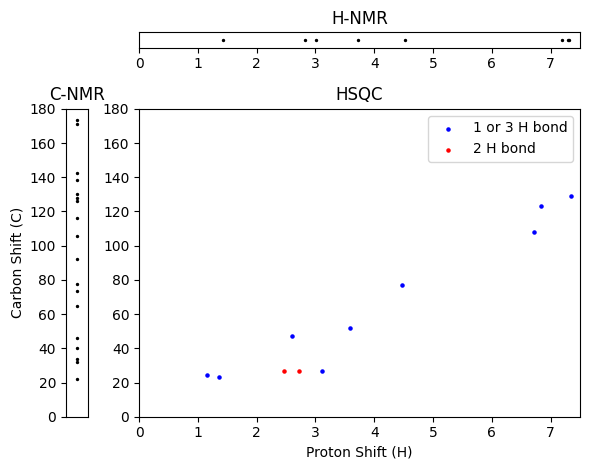

Chemical name Aspergilline A
Ground truth smiles CN1C(=O)C23OC4(O)C(O)C(=O)N5C(C)(C)C(Cc6cccc1c62)C3C54O


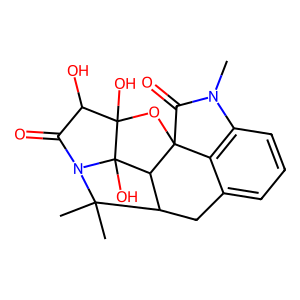

Prediction's cosine similarity to ground truth:  0.7512285113334656
SMILES: COC(=O)CCCN1C(=O)C23OC4(O)C(O)C(=O)N5C(C)(C)C(Cc6cccc1c62)C3C54O
Name Aspergilline B


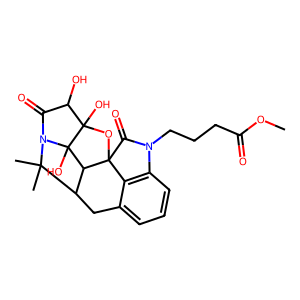

In [17]:
'''
show some examples from my dataset to check sanity
for a single model, show top-5
'''

# model.to("cuda")
for  which_compound in  random.sample(range(len(loader_all_inputs.dataset)), k=1):# range(0, 1):  
    
    print(f"############################################### compound number: {which_compound+1}##############################################################")
    
    for idx, batch in enumerate(loader_all_inputs):
        if idx < which_compound:
            continue
        inputs, (smiles_chemical_name) = batch
        # print(inputs.shape, inputs)
        # print(inputs, smiles_chemical_name)
        
        # batch[0] = batch[0].to("cuda")
        hsqc, c_tensor, h_tensor = unpack_inputs(inputs)
        inputs = inputs.to("cuda")
        pred = model(inputs)
        pred=torch.sigmoid(pred) # sigmoid
        pred_FP = torch.where(pred.squeeze()>0.5, 1, 0)
        # print(pred_FP.nonzero().squeeze().tolist())
        break
    # print(f"dataloader: {loader_all_inputs.dataset.latest_element_got}")
    
    # print(inputs)
    
    print("Ground Truth NMR")
    plot_NMR(hsqc, c_tensor, h_tensor)
    
    topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=1)
    # ground truth
    smiles, names, path = zip(*smiles_chemical_name)
    mol = Chem.MolFromSmiles(smiles[0])
    print(f"Chemical name {names[0]}")
    print(f"Ground truth smiles {smiles[0]}")
    # print(f"Ground truth NMR path {path[0]}")
    img = Draw.MolToImage(mol)
    img.show()
    
    ground_truth_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(smiles[0])
    print("Prediction's cosine similarity to ground truth: ", compute_cos_sim(ground_truth_FP, pred_FP.to("cpu").float()).item())
    
    i=0
    for value, (smile, name, _, _), retrieved_FP in topk:
        # print(f"________retival #{i+1}, cosine similarity: {value.item()}_________________")
        mol = Chem.MolFromSmiles(smile)
        # print("retrived FP", retrieved_FP.squeeze().tolist())
        hsqc_path, oned_path = smiles_to_NMR_path[smile]
        #check is path file exists
        hsqc, c_tensor, h_tensor = None, None, None
        # print("retrieved path: ",oned_path)
        if os.path.exists(hsqc_path):
            hsqc = torch.load(hsqc_path)
        if os.path.exists(oned_path):
            c_tensor, h_tensor = torch.load(oned_path)
        # plot_NMR(hsqc, c_tensor, h_tensor)
        print(f"SMILES: {smile}")
        print(f"Name {name}")
        img = Draw.MolToImage(mol)
        img.show()
        i+=1
        



In [18]:
# '''
# Show only incorrect inference examples
# '''

# # model.to("cuda")
# i=0
# for idx, batch in enumerate(loader_all_inputs):
    
#     inputs, (smiles_chemical_name) = batch
#     hsqc, c_tensor, h_tensor = unpack_inputs(inputs)
#     inputs = inputs.to("cuda")
#     pred = model(inputs)
#     pred=torch.sigmoid(pred) # sigmoid
#     pred_FP = torch.where(pred.squeeze()>0.5, 1, 0)
#     # print(pred_FP.nonzero().squeeze().tolist())

    
#     topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=1)
#     # ground truth
#     smiles, names, path = zip(*smiles_chemical_name)
    
#     ground_truth_smiles = smiles[0]
    
    
#     for value, (smile, name, _, _), retrieved_FP in topk:
#         if smile != ground_truth_smiles:
#             i+=1
#             print(f"____________________incorrect retival #{i+1}________________________")
#             print("Ground Truth NMR")
#             plot_NMR(hsqc, c_tensor, h_tensor)
#             ground_truth_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(ground_truth_smiles)
#             print("Prediction's cosine similarity to ground truth: ", compute_cos_sim(ground_truth_FP, pred_FP.to("cpu").float()).item())
            
            
            
#             mol = Chem.MolFromSmiles(smiles[0])
#             print(f"Chemical name {names[0]}")
#             print(f"Ground truth smiles {smiles[0]}")
#             # print(f"Ground truth NMR path {path[0]}")
#             img = Draw.MolToImage(mol)
#             img.show()

           
#             mol = Chem.MolFromSmiles(smile)
           
#             print(f"SMILES: {smile}")
#             print(f"Name {name}")
#             img = Draw.MolToImage(mol)
#             img.show()
    
#     if i==80:
#         break    
        
        
        


    



In [19]:
idx

3535

In [20]:
def get_delimeter(delimeter_name):
    match delimeter_name:
        case "HSQC_start":
            return torch.tensor([-1,-1,-1]).float()
        case "HSQC_end":
            return torch.tensor([-2,-2,-2]).float()
        case "C_NMR_start":
            return torch.tensor([-3,-3,-3]).float()
        case "C_NMR_end":
            return torch.tensor([-4,-4,-4]).float()
        case "H_NMR_start":
            return torch.tensor([-5,-5,-5]).float()
        case "H_NMR_end":
            return torch.tensor([-6,-6,-6]).float()
        case "solvent_start":
            return torch.tensor([-7,-7,-7]).float()
        case "solvent_end":
            return torch.tensor([-8,-8,-8]).float()
        case "ms_start":
            return torch.tensor([-12,-12,-12]).float()
        case "ms_end":
            return torch.tensor([-13,-13,-13]).float()
        case _:
            raise Exception(f"unknown {delimeter_name}")

 

In [21]:


"""
Nice !
Now we can play with unkown molecule
"""
hsqc_mode = None
'''for a single model, show top-5'''
def show_topK(inputs, k=5, mode = hsqc_mode, ground_truth_FP=None):
    print("_________________________________________________________")

    
    inputs = inputs.unsqueeze(0).to("cuda")
    pred = model(inputs)
    pred = torch.sigmoid(pred) # sigmoid
    pred_FP = torch.where(pred.squeeze()>0.5, 1, 0)
    # print(pred_FP.nonzero().squeeze().tolist())
    if ground_truth_FP is not None:
        print("Prediction's cosine similarity to ground truth: ", compute_cos_sim(ground_truth_FP, pred_FP.to("cpu").float()))
        print("\n\n")
    topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=k)
       
    
    i=0
    for ite, (value, (smile, name, _, _), retrieved_FP) in enumerate(topk):
        print(f"____________________________retival #{i+1}, retrival cosine similarity to prediction: {value.item()}_____________________________")
        mol = Chem.MolFromSmiles(smile)
        # print("retrived FP", retrieved_FP.squeeze().tolist())
        if ground_truth_FP is not None:
            retrieved_FP_6144 = torch.zeros(6144)
            retrieved_FP_6144[retrieved_FP.cpu()] = 1
            print("Retrival's cosine similarity to ground truth: ", compute_cos_sim(ground_truth_FP, retrieved_FP_6144))
        print(f"SMILES: {smile}")
        print(f"Name {name}")
        hsqc_path, oned_path = smiles_to_NMR_path[smile]
        #check is path file exists
        hsqc, c_tensor, h_tensor = None, None, None
        # print("retrieved path: ",oned_path)
        if os.path.exists(hsqc_path):
            hsqc = torch.load(hsqc_path)
        if os.path.exists(oned_path):
            c_tensor, h_tensor = torch.load(oned_path)
            
        if hsqc is not None:
            if mode == "no_sign":
                hsqc = torch.abs(hsqc)
            elif mode == "flip_sign":
                hsqc[:,2] = -hsqc[:,2]
        # plot_NMR(hsqc, c_tensor, h_tensor)
        img = Draw.MolToImage(mol)
        img.show()
        i+=1
        



In [22]:
def build_input(compound_dir, mode = hsqc_mode, include_hsqc = True, include_c_nmr = True, include_h_nmr = True):
    print("\n\n")
    print(compound_dir.split("/")[-1])
    print("\n")
    def load_2d():
        return torch.tensor(np.loadtxt(os.path.join(compound_dir, "HSQC.txt"), delimiter=",")).float()
    def load_1d(nmr):
        vals = np.loadtxt(os.path.join(compound_dir, f"{nmr}.txt"), delimiter=",")
        vals = torch.tensor(np.unique(vals)).float()
        return F.pad(vals.view(-1, 1), (0, 2), "constant", 0)
    
    hsqc = load_2d()
    if hsqc is not None:
        hsqc[:,[0,1]] = hsqc[:,[1,0]]
        if mode == "no_sign":
            hsqc = torch.abs(hsqc)
        elif mode == "flip_sign":
            hsqc[:,2] = -hsqc[:,2]
    c_tensor = load_1d("C")
    h_tensor = load_1d("H")
    input_NMRs = []
    if include_hsqc:
        input_NMRs+= [get_delimeter("HSQC_start"),  hsqc,     get_delimeter("HSQC_end")]
    if include_c_nmr:
        input_NMRs+= [get_delimeter("C_NMR_start"), c_tensor, get_delimeter("C_NMR_end")]
    if include_h_nmr:
        input_NMRs+= [get_delimeter("H_NMR_start"), h_tensor, get_delimeter("H_NMR_end")]
    inputs = torch.vstack(input_NMRs)   
    with open(os.path.join(compound_dir, "mw.txt"), 'r') as file:
        # Read the content of the file
        content = file.read()
        # Convert the content to a float
        mw = float(content)
    mol_weight = torch.tensor([mw,0,0]).float()
    # print(inputs)
    # print(hsqc, c_tensor, h_tensor)
    # plot_NMR(hsqc, c_tensor[:,0], h_tensor[:,0])
    return torch.vstack([inputs, get_delimeter("ms_start"), mol_weight, get_delimeter("ms_end")])

In [23]:
Kavaratamide_A_SMILES = "CCCCCCC[C@H](O)CC(=O)N[C@@H](C(C)C)C(=O)N(C)[C@@H](C)C(=O)O[C@@H](C(C)C)C(=O)N1[C@@H](C(C)C)C(OC)=CC1=O"
Kavaratamide_A_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(Kavaratamide_A_SMILES)

newCompoundA_SMILES = "O=C1C(NC2=O)CCC(O)N1C(CC3=CC=CC=C3)C(N(C)C(CC4=CC(Br)=C(O)C=C4)C(NC(C(CC)C)C(OC(C)C(C(NC2CCCC[NH3+])=O)NC(C(NC(C(COS(=O)([O-])=O)OC)=O)CC5=CC=CC=C5)=O)=O)=O)=O"
newCompoundA_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(newCompoundA_SMILES)

In [24]:
(newCompoundA_FP.dtype)

torch.float32

In [25]:
# look for the higher cos_sim possible in our dataset
def  retrieve_based_on_groudth(groud_truth_FP, k=5):
    topk = retrieve_top_k_by_rankingset(rankingset_data, groud_truth_FP, smiles_and_names, k=k) 
    
    i=0
    for ite, (value, (smile, name, _, _), retrieved_FP) in enumerate(topk):
        print(f"____________________________retival #{i+1}, cosine similarity: {value.item()}_____________________________")
        mol = Chem.MolFromSmiles(smile)
        print("retrived FP", retrieved_FP.squeeze().tolist())
        print(f"SMILES: {smile}")
        print(f"Name {name}")
        #check is path file exists
        # plot_NMR(hsqc, c_tensor, h_tensor)
        img = Draw.MolToImage(mol)
        img.show()
        i+=1


____________________________retival #1, cosine similarity: 0.7337204813957214_____________________________
retrived FP [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 26, 27, 28, 29, 30, 31, 37, 38, 41, 42, 43, 63, 64, 65, 67, 68, 72, 73, 79, 87, 90, 113, 114, 116, 117, 119, 123, 124, 125, 128, 130, 133, 135, 136, 137, 138, 139, 143, 169, 178, 180, 181, 187, 191, 192, 193, 195, 196, 214, 217, 224, 226, 228, 230, 231, 232, 233, 237, 239, 241, 242, 244, 248, 282, 286, 287, 292, 370, 371, 373, 491, 492, 508, 516, 522, 590, 591, 592, 593, 594, 603, 620, 626, 647, 660, 661, 662, 666, 734, 750, 751, 814, 826, 846, 861, 866, 960, 1013, 1014, 1045, 1090, 1240, 1309, 1330, 1337, 1381, 1420, 1485, 1691, 1952, 2116, 2151, 2247, 2249, 2302, 2488, 2493, 2517, 2676, 2906, 2921, 3013, 3239, 3397, 3635, 3703, 3804, 3818, 3949, 4030, 4048, 4100, 4214, 4387, 4399, 4659, 4779, 4985, 5419, 5432, 5534, 5954, 6123]
SMILES: CCCCCCCC(CC=CCCC(=O)N(C)C(C)C(=O)NC(C)C(O)C(C)C(=O)N1C(=O)C=C(OC)C1C(C)C)OC
Name malyngamide X


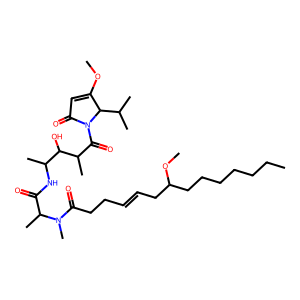

____________________________retival #2, cosine similarity: 0.6856179237365723_____________________________
retrived FP [0, 1, 5, 6, 12, 13, 14, 15, 26, 27, 28, 29, 30, 31, 37, 38, 41, 42, 43, 63, 64, 65, 67, 68, 72, 73, 79, 87, 90, 108, 109, 110, 111, 112, 114, 116, 117, 132, 134, 135, 136, 137, 138, 139, 140, 144, 191, 192, 193, 195, 196, 214, 230, 231, 232, 233, 239, 241, 242, 244, 248, 259, 263, 280, 356, 363, 370, 371, 373, 375, 393, 404, 491, 492, 516, 522, 558, 576, 590, 591, 592, 593, 594, 603, 620, 647, 660, 661, 662, 666, 702, 713, 722, 734, 742, 750, 751, 780, 788, 792, 822, 826, 866, 942, 1024, 1143, 1217, 1284, 1330, 1381, 1421, 1441, 1504, 1637, 1685, 1691, 1867, 1950, 2040, 2133, 2151, 2247, 2265, 2442, 2488, 2493, 2647, 2807, 2891, 2921, 2953, 3121, 3334, 3421, 3652, 3742, 3949, 3952, 4100, 4214, 4399, 4642, 4673, 4730, 4963, 5316, 5432, 5534, 5832, 6107]
SMILES: CCC(C)C(OC(=O)C(CC(C)C)N(C)C)C(=O)NC(C(=O)N1CCCC1C(=O)N1C(=O)C=C(OC)C1C(C)C)C(C)C
Name 102147668


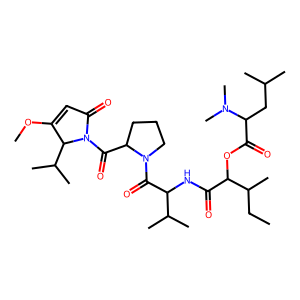

In [26]:
retrieve_based_on_groudth(Kavaratamide_A_FP.unsqueeze(dim=0).to("cuda"), k=2)

In [27]:
deepSAT_sintokamide_B_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES("CCC(=O)N[C@H](C[C@H](C)C(Cl)(Cl)Cl)C(=O)N1[C@H](C(=CC1=O)OC)C[C@H](C)C(Cl)(Cl)Cl")
compute_cos_sim(deepSAT_sintokamide_B_FP, Kavaratamide_A_FP)

tensor(0.6227116585)




Kavaratamide A


_________________________________________________________
Prediction's cosine similarity to ground truth:  tensor(0.5475035906)



____________________________retival #1, retrival cosine similarity to prediction: 0.6726547479629517_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.4389235973)
SMILES: CC=C(NC(=O)CC(O)CCCCCCCCCCC)C(=O)NC1C(=O)NC(C(C)O)C(=O)NC(CC(C)C)C(=O)NCC(=O)NC(CCC(N)=O)C(=O)NCC(=O)N(C)C(C(C)O)C(=O)NC(CCCN=C(N)N)C(=O)OC1C
Name 74188-24-2


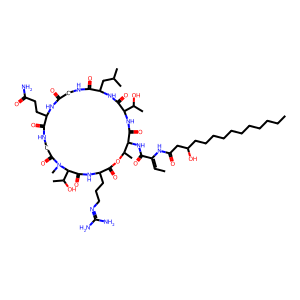

____________________________retival #2, retrival cosine similarity to prediction: 0.6705427169799805_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.4325701892)
SMILES: CCCCCCCCCCCCCCC(C)C1OC(=O)C(CO)NC(=O)C(C(C)O)NC(=O)C(C(C)C)NC(=O)C1C
Name 147334-88-1


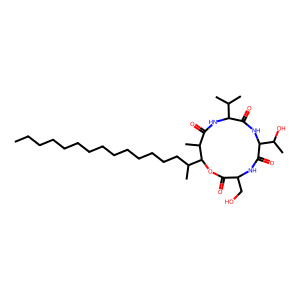

____________________________retival #3, retrival cosine similarity to prediction: 0.6705427169799805_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.4325701892)
SMILES: CCCCCCCCCCC(C)C1OC(=O)C(CO)NC(=O)C(C(C)O)NC(=O)C(C(C)C)NC(=O)C1C
Name NCGC00381435-01!13-dodecan-2-yl-6-(1-hydroxyethyl)-3-(hydroxymethyl)-12-methyl-9-propan-2-yl-1-oxa-4,7,10-triazacyclotridecane-2,5,8,11-tetrone


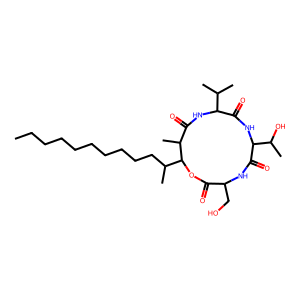

____________________________retival #4, retrival cosine similarity to prediction: 0.6643402576446533_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.4868612289)
SMILES: CCCCCCC=CCCCCCC(O)CC(=O)NC(CC(C)C)C(=O)NC1C(=O)NC(CO)C(=O)NC(C(C)O)C(=O)NC(CC(C)C)C(=O)NC(CC(C)C)C(=O)OC1C
Name ngercheumicin H


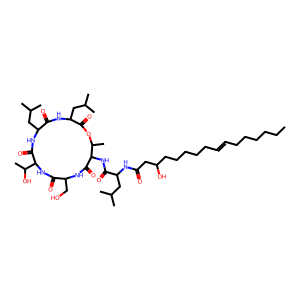

____________________________retival #5, retrival cosine similarity to prediction: 0.6603826880455017_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.4266845882)
SMILES: CCCCCCCCCCCCCC(O)C(C)C1OC(=O)C(CO)NC(=O)C(C(C)O)NC(=O)C(C(C)C)NC(=O)C1C
Name Stevastelin-C3


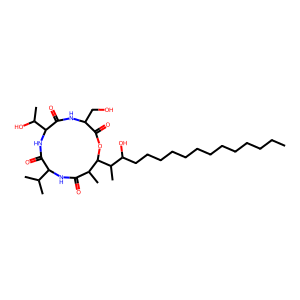

In [28]:
compound_dir = "/root/MorganFP_prediction/inference_data/testing_compounds/Kavaratamide A"
mode = None#"flip_sign"
inputs = build_input(compound_dir, mode=mode,
                     include_h_nmr=False, include_c_nmr=False
                     )
show_topK(inputs, k=5, mode=mode, ground_truth_FP = Kavaratamide_A_FP)
# show_topK(inputs, k=1)

In [33]:
# retrieve_based_on_groudth(newCompoundA_FP.unsqueeze(dim=0).to("cuda"), k=2)




new_compound_A


_________________________________________________________
Prediction's cosine similarity to ground truth:  tensor(0.7257776856)



____________________________retival #1, retrival cosine similarity to prediction: 0.7850006818771362_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.7223570347)
SMILES: CCC(C)C1NC(=O)C(Cc2ccccc2)N(C)C(=O)C(C(C)CC)N2C(=O)C(CCC2OC)NC(=O)C(CCCN=C(N)N)NC(=O)C(NC(=O)C(O)CO)C(C)OC1=O
Name micropeptin MZ859


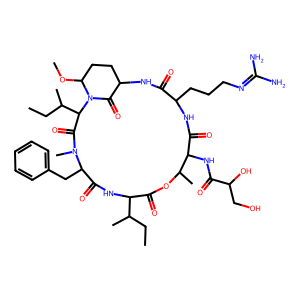

____________________________retival #2, retrival cosine similarity to prediction: 0.783405601978302_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.8036287427)
SMILES: CCC(C)C1NC(=O)C(Cc2ccccc2)N(C)C(=O)C(C(C)CC)N2C(=O)C(CCC2O)NC(=O)C(CCc2ccc(O)cc2)NC(=O)C(NC(=O)C(CO)OC)C(C)OC1=O
Name Cyanopeptolin 880


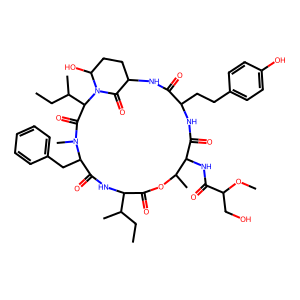

____________________________retival #3, retrival cosine similarity to prediction: 0.7775808572769165_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.7339333892)
SMILES: CCC(C)C1NC(=O)C(Cc2ccccc2)N(C)C(=O)C(C(C)CC)N2C(=O)C(CCC2OC)NC(=O)C(CCCN=C(N)N)NC(=O)C(NC(=O)C(CO)OS(=O)(=O)O)C(C)OC1=O
Name micropeptin MZ939B


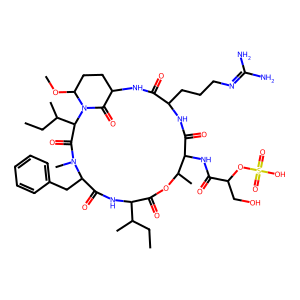

In [34]:
compound_dir = "/root/MorganFP_prediction/inference_data/testing_compounds/new_compound_A"
inputs = build_input(compound_dir,
                     mode=mode,
                     include_h_nmr=False, include_c_nmr=False
                     )
show_topK(inputs, k=3, ground_truth_FP=newCompoundA_FP)




new_compound_B1


_________________________________________________________
____________________________retival #1, retrival cosine similarity to prediction: 0.7557245492935181_____________________________
SMILES: CCCCCCCCCCCCCCC(=O)NC(CCCN)C(=O)NC(C(=O)NC1C(=O)NC(CCCN)C(=O)NC(CO)C(=O)NC(C(C)C)C(=O)NC(CCCCN)C(=O)NC(CO)C(=O)NC(C(C)CC)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(CCCCN)C(=O)NC(C(C)CC)C(=O)OC1C)C(C)C
Name Paenibacterin


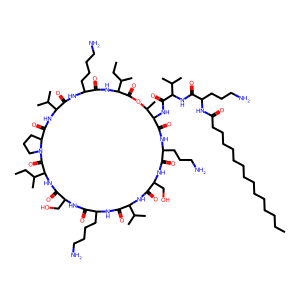

____________________________retival #2, retrival cosine similarity to prediction: 0.7538677453994751_____________________________
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name kahalalide F


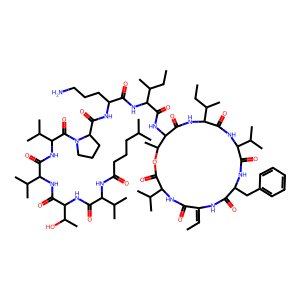

____________________________retival #3, retrival cosine similarity to prediction: 0.7527674436569214_____________________________
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)C)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(CCC(=O)O)NC(=O)CCCCCC(C)C)C(C)C)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name kahalalide R


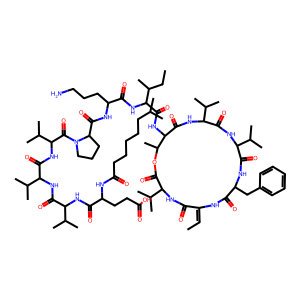

In [35]:
compound_dir = "/root/MorganFP_prediction/inference_data/testing_compounds/new_compound_B1"
inputs = build_input(compound_dir,
                     mode=mode,
                     include_h_nmr=False, include_c_nmr=False
                     )
show_topK(inputs, k=3)




new_compound_B2


_________________________________________________________
____________________________retival #1, retrival cosine similarity to prediction: 0.7878141403198242_____________________________
SMILES: CCCC(=O)NC(C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name xentrivalpeptide D


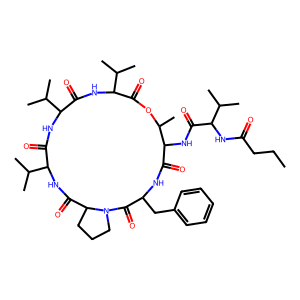

____________________________retival #2, retrival cosine similarity to prediction: 0.7841081023216248_____________________________
SMILES: CCC(C)C1NC(=O)C(C(C)C)NC(=O)C2CCCN2C(=O)C(Cc2ccccc2)NC(=O)C(NC(=O)C(NC(=O)Cc2ccccc2)C(C)C)C(C)OC(=O)C(C(C)C)NC1=O
Name Xentrivalpeptide N


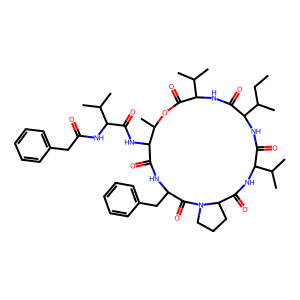

____________________________retival #3, retrival cosine similarity to prediction: 0.7729668617248535_____________________________
SMILES: CCCCCC(=O)NC(C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name Xentrivalpeptide G


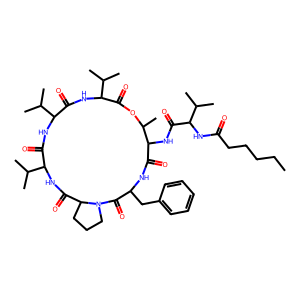

____________________________retival #4, retrival cosine similarity to prediction: 0.772759735584259_____________________________
SMILES: CCCC(=O)NC(C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(CC)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name Xentrivalpeptide P


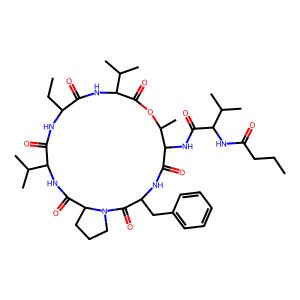

____________________________retival #5, retrival cosine similarity to prediction: 0.7679193615913391_____________________________
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name kahalalide F


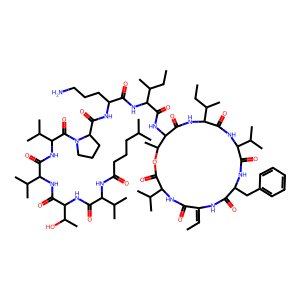

In [36]:
compound_dir = "/root/MorganFP_prediction/inference_data/testing_compounds/new_compound_B2"
inputs = build_input(compound_dir,
                     mode=mode,
                     include_h_nmr=False, include_c_nmr=False
                     )
show_topK(inputs, k=5)